In [1]:
from itertools import product

import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

from auxiliary import plot_interventional_distribution
from auxiliary import plot_conditional_distribution

# Causal graphs

### Introduction

Graph notation less general than potential outcome framework, but 

* thinking about causal systems
* uncover identification strategies

> It is useful to separate the inferential problem into statistical and identification components. Studies of identification seek to characterize the conclusions that could be drawn if one could use the sampling process to obtain an unlimited number of observations. (Manski, 1995)

The two most crucial ingredients for an identification analysis are:

* The set of assumptions about causal relationships that the analysis is willing to assert based on theory and past research, including assumptions about relationships between variables that have not been observed but that are related both to the cause and outcome of interest.

* The pattern of information one can assume would be contained in the joint distribution of the variables (**associations**) in the observed dataset if all members of the population had been included in the sample that generated the dataset.

$\rightarrow$ causal graphs offer an effective and efficient representation for both

### Basic elements of causal graphs

* nodes
* edges
* directed paths
    * parent and child
    * descendant

<img src="material/fig-graph-with-cycle.png" width=200 />

Two representations of the joint dependence of $A$ and $B$ on an unobserved common cause.

<img src="material/fig-graph-shorthand-unobserved-common-cause.png" width=500 />

Let's look at some basic patterns that will turn out to appear frequently.

* chain of mediation
* fork of mutual causation
* inverted fork of mutual dependence

<img src="material/fig-basic-causal-relationships.png" width=200 />

What about the unconditional and conditional association of $A$ and $B$ in each of these cases?

* While there is unconditional dependence between them in the first two cases, there is not in the third.

The **collider variable** $C$ in the third setting does not generate an unconditional association between $A$ and $B$. However, as we will revisit in more detail later, it can create a conditional association that needs to be handled with care.

#### Conditioning and confounding

<img src="material/fig-confounding-variable.png" width=500 />


The causal effects $C \rightarrow D$ and $C \rightarrow Y$ render the total association between $D$ and $Y$ unequal to the causal effect $D \rightarrow Y$.

* $C$ is a **confounding variable** that affects both the dependent and independent variable.

* Conditioning is a modelig strategy that allows to determine causal effects in the presence of observed confounders.

$\rightarrow$ What happens if $C$ is unobserved?

How about an example from educational choice where we have observed and unobserved confounders?

<img src="material/fig-confounders-education.png" width=500 />

What identification strategies come to mind?

### Link to structural equations

Let's look at another example and assume we are interested in the effect of parental background (P), charter schools (D), and neighborhoods (N) on test scores (Y).

We could set up the following **linear** regression equations:

\begin{align*}
D & = \alpha_D + b_P P + \epsilon_2 \\
Y & = \alpha_Y + b_D D + b_P P + + b_N N + \epsilon_4
\end{align*}

<img src="material/fig-equivalent-representations-standard.png" width=500 />

<img src="material/fig-equivalent-representations-magnified.png" width=500 />

We can set up the same *nonparametric* structural equations for both representations:

\begin{align*}
P & = f_P(\epsilon_1)    \\
N & = f_N(\epsilon_3) \\
D & = f_D(P, \epsilon_2) \\
Y & = f_Y(P, D, N, \epsilon_4)
\end{align*}

How to simulate a sample from a set of structural equations?

In [2]:
indices = list()
[indices.append(label) for label in product([("alpha")], ("D", "Y"))]
[indices.append(label) for label in product([("beta")], ("P", "N", "D"))]
index = pd.MultiIndex.from_tuples(indices, names=["group", "element"])

values = [1, 1, 0.8, 0.7, -0.3]
params = pd.Series(values, index=index)

# distributional assumptions
get_unobservable = np.random.normal
get_observable = np.random.uniform


num_agents = 10000

df = pd.DataFrame(columns=["Y", "D", "P", "N"])

for i in range(num_agents):
    P, N = get_observable(size=2)

    D = params.loc["alpha", "D"] + params.loc["beta", "P"] * P + get_unobservable()

    Y = (
        params.loc["alpha", "Y"]
        + params.loc["beta", "D"] * D
        + params.loc["beta", "P"] * P
        + params.loc["beta", "N"] * N
        + get_unobservable()
    )

    df.loc[i] = [Y, D, P, N]


df.head()

,Y,D,P,N
0,1.248681,3.289100,0.928133,0.297718
1,1.791849,1.665443,0.221006,0.472631
2,1.181537,0.400000,0.366633,0.706849
3,1.875180,1.226666,0.189232,0.916127
4,3.442131,1.271353,0.025105,0.976486


Now lets see if we can uncover the structural parameters by a simple ordinary-least-squares regression and thus go full circle from a parametric structural equation model to a causal graph.

In [3]:
params

group  element
alpha  D          1.0
       Y          1.0
beta   P          0.8
       N          0.7
       D         -0.3
dtype: float64

In [4]:
smf.ols(formula="Y ~ D + P + N", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     556.2
Date:                Tue, 04 May 2021   Prob (F-statistic):               0.00
Time:                        21:05:08   Log-Likelihood:                -14101.
No. Observations:               10000   AIC:                         2.821e+04
Df Residuals:                    9996   BIC:                         2.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9686      0.028     34.853      0.000       0.914       1.023
D             -0.2997      0.010    -30.384      0.000      -0.319      -0.280
P              0.8276      0.035     23.439      0.000       0.758       0.897
N              0.7401      0.034     21.574      0.000       0.673       0.807
==============================================================================
Omnibus:                        2.466   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.291   Jarque-Bera (JB):                2.400
Skew:                          -0.010   Prob(JB):                        0.301
Kurtosis:                       2.927   Cond. No.                         8.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Link to potential outcome model

Advantages of the potential outcome model

* definition of causal effects
* individual effects as first principle
* decomposition of sources of inconsistency
* ...

However, it is hard to manage the notion for larger causal systems with many confounding variables and treatments.

<img src="material/fig-observed-confounding-variable.png" width=500 />

Based on our previous discussion, unfortunately, $E[Y_1 - Y_0] \neq E[Y\mid D = 1] - E[Y\mid D = 0]$. 

How can we define the treatment effects from the potential outcome model in here?

> Interventions and counterfactuals are defined through a mathematical operator called $do(\cdot)$, which simulates physical interventions by deleting certain functions from the model, replacing them with a constant. (Pearl, 2012)

\begin{align*}
E[Y_1 - Y_0 ]\quad\text{corresponds to}\quad E[Y \mid do(D=1)] - E[Y \mid do(D=0)]
\end{align*}

The $do(\cdot)$ operator is the exact analog to the superscripts given to potential outcomes in order to designate the underlying causal states that define them.

Graphical presentation of $do(\cdot)$ operator

<img src="material/fig-mutilated-graph.png" width=500 />

The $do(\cdot)$ operator induces a key distinction between the **conditional distribution** of the endogenous variable and its **interventional distribution**.

Let's simulate a sample from a parametrized version of the graph above.

In [5]:
np.random.seed(123)

num_agents = 1000
df = pd.DataFrame(columns=["Y", "D", "C"])


def calculate_outcome(C, D):
    """We compute the observed outcome."""
    # If you would like to have it in potential
    # outcome notation.
    Y_1 = 1 + C
    Y_0 = 0 + C
    Y = D * Y_1 + (1 - D) * Y_0

    # So what is the individual treatment effect?

    return Y


for i in range(num_agents):
    C = np.random.uniform()
    D = np.random.choice([0, 1], p=[C, 1 - C])
    Y = calculate_outcome(C, D)
    df.loc[i] = [Y, D, C]

df.head()

,Y,D,C
0,1.696469,0.0,0.696469
1,1.226851,1.0,0.226851
2,1.719469,0.0,0.719469
3,1.980764,0.0,0.980764
4,1.480932,0.0,0.480932


We know how to compute and plot a **conditional distribution**.

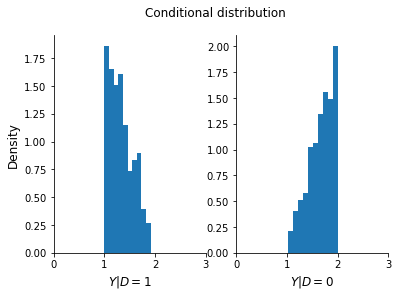

In [6]:
plot_conditional_distribution(df)

How can we compute the **interventional distribution**? What do we need to know to do that?

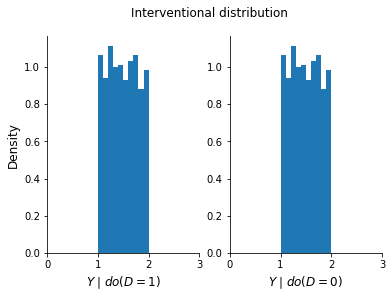

In [7]:
Y_do_1, Y_do_0 = list(), list()
for i, row in df.iterrows():
    # Note that we calculate the outcome using the
    # individual"s actual C put simply set D to
    # its value unter the intervetion.
    C, D = row["C"], 1
    Y_do_1 += [calculate_outcome(C, D)]

    C, D = row["C"], 0
    Y_do_0 += [calculate_outcome(C, D)]

plot_interventional_distribution(Y_do_1, Y_do_0)

### Resources

* **Manski, C. F. (1995)**. *Identification problems in the social sciences*. Cambridge, UK: Harvard University Press.  


* **Pearl, J. (2012)**. *The do-calculus revisited.* *arXiv preprint arXiv:1210.4852*.


* **Peters, J., Janzig, D., and Schölkopf, B. (2018)**. *Elements of causal inference: Foundations and learning algorithms*. Cambridge, MA: The MIT Press.


* **Imbens, G. W. (2020)**. *Potential outcome and directed acyclic graph approaches to causality: Relevance for empirical practice in economics*. https://arxiv.org/abs/1907.07271


* **Hünermund, P. and Bareinboim, E. (2019)**. *Causal inference and data-fusion in econometrics.* *arXiv preprint arXiv:1912.09104*.